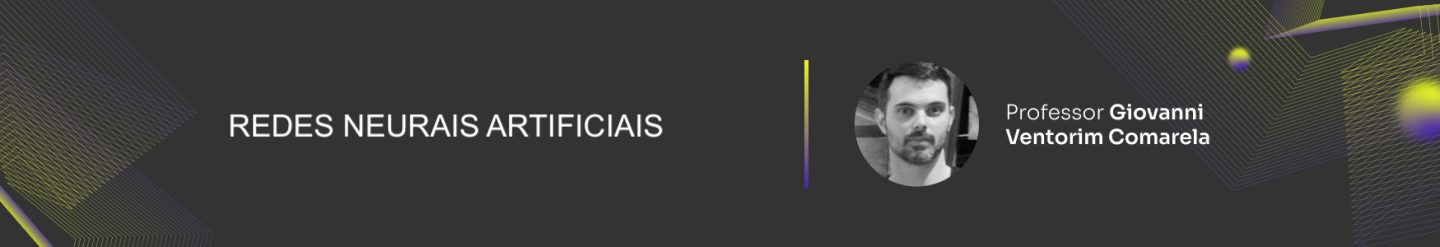

# Aplicações em Séries Temporais

Nas aulas anteriores, vimos teoria e prática envolvendo MLPs, focando em problemas de **classificação** e **regressão**.

Nesta aula, veremos um exemplo de como MLPs podem ser utilizadas no contexto de Séries Temporais.

Para isso, estudaremos um exemplo baseado/adaptado [daqui](https://github.com/zakarm/MLP-TimeSeries-Forecaster/blob/main/MLP.ipynb).

**Observação:** MLPs conseguem fazer um trabalho "razoável" para previsão de séries temporais em alguns cenários. No entanto, é importante mencionar que as MLPs não são as redes neurais mais indicadas para tal tarefa. Nas próximas disciplinas do curso, vocês verão redes mais adequadas para séries temporais.

## Conjunto de dados

Os dados que usaremos de exemplo são relativos ao número de passageiros, por mês, de uma companhia aérea. Esse é um conjunto de dados antigo e comumente utilizado como exemplo no estudo de séries temporais.

Os dados podem ser obtidos [aqui](https://raw.githubusercontent.com/zakarm/MLP-TimeSeries-Forecaster/refs/heads/main/AirPassengers.csv).

Baixando o conjunto de dados.

In [ ]:
!wget https://raw.githubusercontent.com/zakarm/MLP-TimeSeries-Forecaster/refs/heads/main/AirPassengers.csv

--2025-04-27 18:24:17--  https://raw.githubusercontent.com/zakarm/MLP-TimeSeries-Forecaster/refs/heads/main/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1746 (1.7K) [text/plain]
Saving to: ‘AirPassengers.csv.10’

AirPassengers.csv.1 100%[===================>]   1.71K  --.-KB/s    in 0s      

2025-04-27 18:24:17 (18.0 MB/s) - ‘AirPassengers.csv.10’ saved [1746/1746]



Lendo o conjunto de dados e visualizando a série temporal.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

In [ ]:
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


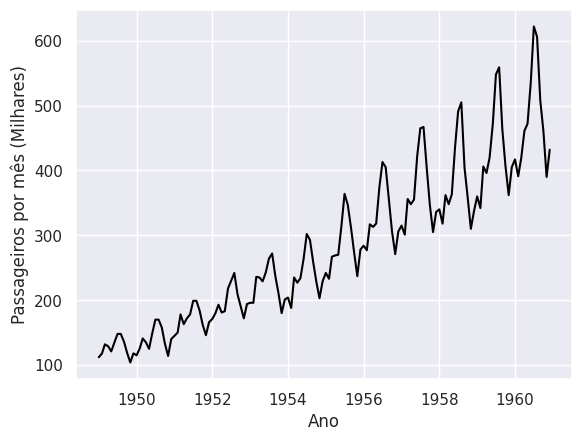

In [ ]:
#@title

import seaborn as sns
sns.set()
fig, ax = plt.subplots()
plt.xlabel('Ano')
plt.ylabel('Passageiros por mês')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'));

Da figura acima, pode-se perceber que o conjunto de dados tem um forte padrão. Em especial, pode-se dar destaque para:
- A tendência de crescimento
- A sazonalidade da série.

**Pergunta** Seria uma MLP capaz de aprender esse padrão e fazer previsões para o número de passageiros mensais da companhia aérea?

## Modelagem do Problema

Uma abordagem comum para utilizar MLPs para realizar previsão de séries temporais é transformar o problema original em um problema de regressão.

Denote a série temporal de interesse por $x_1, x_2, ..., x_n$.
A ideia é transoformar essa série em um conjunto $D = \{(\mathbf{x}_i, y_i)\}_{i = 1}^m$, onde $\mathbf{x}_i \in \mathbb{R}^d$ e $y_i \in \mathbb{R}$.

Para isso, variaremos um contador $t$ de $d+1$ até $n$. Assim, para cada $t$:
- $\mathbf{x}_{t} = [x_{t-d}, x_{t-d+1}, \dots, x_{t-1}]^T$; e
- $y_{t}$ = $x_t$.

Em outras palavras, vamos criar um problema de regressão, onde, num tempo $t$, as características (*features*) são as últimas $d$ observações e tem-se interesse em predizer o valor da série no tempo $t$.

Para os dados do exemplo sendo considerado, o código abaixo realiza tal transformação. No caso, vamos utilizar $d = 12$, uma vez que o dados demonstram uma forte componente sazonal.

In [ ]:
d = 12

In [ ]:
Z = []
for t in range(d + 1, df.shape[0] + 1):
  Z.append(df.iloc[(t - d - 1): t, 0])
Z = np.array(Z)

In [ ]:
X = Z[:, :-1] # matriz de features
y = Z[:, -1]  # valores a serem preditos

Como próximo passo, precisamos dividir o conjunto de dados em porções de **treinamento**, **validação** e **teste**.

No caso de séries temporais, essa divisão não pode ser aleatória, uma vez que existe correção entre as observações.

Assim, vamos reservar as 25 últimas observações para o conjunto de teste e as 25 anteriores para o conjunto de validação. A porção restante do conjunto de dados será o conjunto de treinamento.

In [ ]:
X_test, y_test = X[-25:, :], y[-25:]
X_val, y_val = X[-50:-25, :], y[-50:-25]
X_train, y_train = X[:-50, :], y[:-50]

A Figura abaixo ilustra a série temporal com cores diferentes para cada subconjunto.

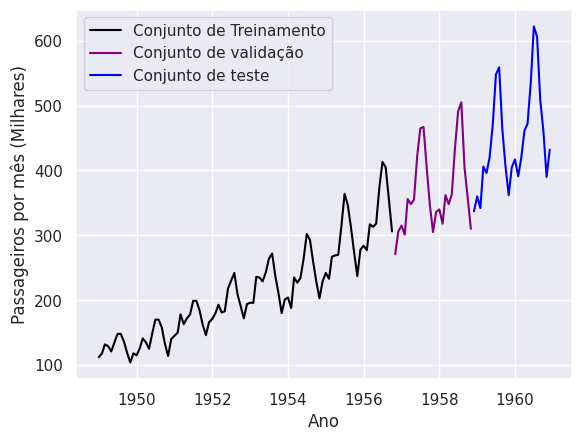

In [ ]:
#@title
fig, ax = plt.subplots()
plt.xlabel('Ano')
plt.ylabel('Passageiros por mês')
plt.plot(df.iloc[:-50, :], color='black', label='Conjunto de Treinamento')
plt.plot(df.iloc[-50:-25, :], color='purple', label='Conjunto de validação')
plt.plot(pd.Series(y_test, index=df.index[-25:]), color='blue', label='Conjunto de teste')
plt.legend(loc = 'best')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Treinamento do Modelo

Com os dados preparados, vamos utilizar a biblioteca `Keras` para realizar a regressão. Para isso, vamos proceder de forma similar às últimas aulas.

In [ ]:
from tensorflow import keras

In [ ]:
# monitor de early stopping para evitar overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           start_from_epoch = 100,
                                           restore_best_weights = True,
                                           patience = 20)

# definição do modelo
model = keras.Sequential([
    keras.layers.Input((12,)),
    keras.layers.Dense(units = 50, activation = "relu",), # uma camada escondia com 50 unidades
    keras.layers.Dense(units = 1, activation = "linear")] # uma cadada de saída com ativação linear
)

# configuração
model.compile(
    loss = "mean_squared_error", # métrica de erro é o erro quadrático médio
)

In [ ]:
# treinamento do modelo
history = model.fit(epochs = 1000, callbacks = [early_stop], validation_data = (X_val, y_val), x = X_train, y = y_train, batch_size= 32, verbose = 2)

Epoch 1/1000
3/3 - 2s - 555ms/step - loss: 32688.9395 - val_loss: 28608.7695
Epoch 2/1000
3/3 - 0s - 34ms/step - loss: 8727.3799 - val_loss: 9518.5195
Epoch 3/1000
3/3 - 0s - 44ms/step - loss: 2999.9058 - val_loss: 4534.6689
Epoch 4/1000
3/3 - 0s - 47ms/step - loss: 1404.3589 - val_loss: 3844.7778
Epoch 5/1000
3/3 - 0s - 46ms/step - loss: 1093.6147 - val_loss: 3798.1431
Epoch 6/1000
3/3 - 0s - 46ms/step - loss: 1020.1132 - val_loss: 3809.6226
Epoch 7/1000
3/3 - 0s - 46ms/step - loss: 1008.2165 - val_loss: 3583.6831
Epoch 8/1000
3/3 - 0s - 47ms/step - loss: 969.7955 - val_loss: 3657.8582
Epoch 9/1000
3/3 - 0s - 47ms/step - loss: 969.6737 - val_loss: 3475.9468
Epoch 10/1000
3/3 - 0s - 47ms/step - loss: 898.4601 - val_loss: 3566.1934
Epoch 11/1000
3/3 - 0s - 45ms/step - loss: 861.0527 - val_loss: 3066.5757
Epoch 12/1000
3/3 - 0s - 33ms/step - loss: 845.9311 - val_loss: 2849.1187
Epoch 13/1000
3/3 - 0s - 52ms/step - loss: 796.5424 - val_loss: 2661.0771
Epoch 14/1000
3/3 - 0s - 38ms/step - 

A Figura abaixo apresenta a evolução da Função de Custo ao longo das épocas.
Pode-se perceber que a função de perda tem um comportamento de decaimento e forte ruído. Do mais, o treinamento foi interrompido antes de a função de perda no conjunto de validação ter degradação significativa, com o intuito de evitar *overfitting*.

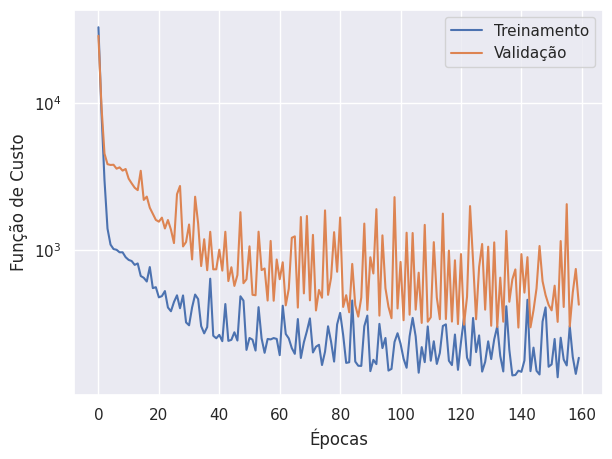

In [ ]:
#@title

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'Treinamento')
plt.plot(history.history['val_loss'], label = 'Validação')
plt.xlabel('Épocas')
plt.ylabel('Função de Custo');
plt.yscale('log')
plt.legend(loc = 'best');

Por fim, podemos utilizar o modelo treinado para predição dos elementos do conjunto de teste e avaliação.

In [ ]:
# predição dos elementos dos conjunto de teste
y_pred = model.predict(X_test).reshape(-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([346.3024 , 360.72092, 356.71667, 369.8099 , 364.66272, 431.35745,
       473.22095, 538.76794, 527.90643, 465.88083, 420.46207, 340.35077,
       374.03918, 391.65613, 411.0808 , 412.88153, 406.9162 , 478.51398,
       529.6606 , 606.6962 , 581.3607 , 526.2705 , 468.60245, 408.01413,
       413.27072], dtype=float32)

A Figura abaixo apresenta uma comparação dos valores reais do conjunto de teste (em azul) com os valores preditos pelo modelo (em vermelho).

Pode-se perceber que as previsões não exatas, mas, em geral, o modelo conseguiu capturar o padrão e o comportamento da série temporal.

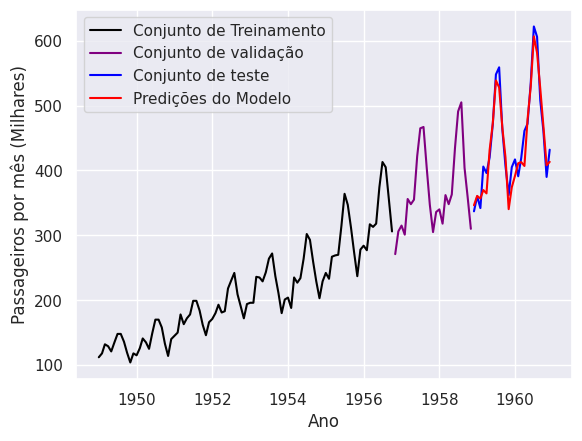

In [ ]:
#@title
fig, ax = plt.subplots()
plt.xlabel('Ano')
plt.ylabel('Passageiros por mês')
plt.plot(df.iloc[:-50, :], color='black', label='Conjunto de Treinamento')
plt.plot(df.iloc[-50:-25, :], color='purple', label='Conjunto de validação')
plt.plot(pd.Series(y_test, index=df.index[-25:]), color='blue', label='Conjunto de teste')
plt.plot(pd.Series(y_pred, index=df.index[-25:]), color='red', label='Predições do Modelo')
plt.legend(loc = 'best')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))